## Прогнозирование невыполнения долговых обязательств по текущему кредиту

Задача:
требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. 

### Требования к решению

Целевая метрика:
* F1 > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

Решение должно содержать:
1. Тетрадка(ки) Jupyter Notebook с кодом Вашего решения
2. Файл CSV с прогнозами целевой переменной для тестового датасета

In [517]:
%matplotlib inline
# Зарузка используемых библиотек
import numpy as np
import pandas as pd
import math
from sklearn.utils import class_weight # балансирование обучающей выборки
from sklearn import preprocessing # препроцессинг фич
from sklearn.model_selection import train_test_split

# Работа с графиками
import matplotlib.pyplot as plt
import seaborn as sns  
from second_func_plot import *

# Работа со статистикой
from scipy.stats import mannwhitneyu, contingency, chi2_contingency 
from statsmodels.sandbox.stats.multicomp import multipletests 
from second_func_stats import *

# Библиотеки, используемые для проектирования моделей
import catboost
import lightgbm as lgb

# Игнорирование warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Установка дефолтных значений для загрузки данных
PATH = "./data"

In [3]:
# Загрузка данных
dataTrain = pd.read_csv(PATH + "/train.csv")
dataTest = pd.read_csv(PATH + "/test.csv")
print("Размерность обучающей выборки =>", dataTrain.shape)
print("Размерность тестовой выборки =>", dataTest.shape)

Размерность обучающей выборки => (7500, 17)
Размерность тестовой выборки => (2500, 16)


### Работа с данными - расчёт статистик, работа с выбросами и аномалиями

1. Просмотр данных - оценка меток, данных на выбросы, пустоты и прочие аномалии;
2. Преобразование типов данных;
3. Построение статистик и выводов по данным;

In [4]:
dataTrain.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


Описание датасета:
    * Home Ownership - домовладение
    * Annual Income - годовой доход
    * Years in current job - количество лет на текущем месте работы
    * Tax Liens - налоговое обременение
    * Number of Open Accounts - количество открытых счетов
    * Years of Credit History - количество лет кредитной истории
    * Maximum Open Credit - наибольший открытый кредит
    * Number of Credit Problems - количество проблем с кредитом
    * Months since last delinquent - количество месяцев с последней просрочки платежа
    * Bankruptcies - банкротства
    * Purpose - цель кредита
    * Term - срок кредита
    * Current Loan Amount - текущая сумма кредита
    * Current Credit Balance - текущий кредитный баланс
    * Monthly Debt - ежемесячный долг
    * Credit Score - кредитный рейтинг

Целевая переменная:
    * Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [5]:
# Проверка выборки на наличие NaN
dataTrain.isnull().any()

Home Ownership                  False
Annual Income                    True
Years in current job             True
Tax Liens                       False
Number of Open Accounts         False
Years of Credit History         False
Maximum Open Credit             False
Number of Credit Problems       False
Months since last delinquent     True
Bankruptcies                     True
Purpose                         False
Term                            False
Current Loan Amount             False
Current Credit Balance          False
Monthly Debt                    False
Credit Score                     True
Credit Default                  False
dtype: bool

In [6]:
dataTrain["Credit Default"].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Выборка несбалансирована - при обучении необходимо это учесть и каждому классу присвоить вес. В обучающей выборке выбросов в метках не наблюдается.
Рассчёт весов классов будем производить с помощью интрумента в sklearn по формуле:

$$вес\thinspaceкласса = \frac{(количество\thinspaceсэмплов)}{2 * (количество\thinspaceсэмплов\thinspaceодного\thinspaceкласса)}$$


In [7]:
class_weights = class_weight.compute_class_weight("balanced", 
                                                  np.unique(dataTrain["Credit Default"]),
                                                  dataTrain["Credit Default"])

### 1. Home Ownership - домовладение

In [8]:
dataTrain["Home Ownership"].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Проверка гипотезы о том, что домовладение не влияет на то, вернет ли человек долг.

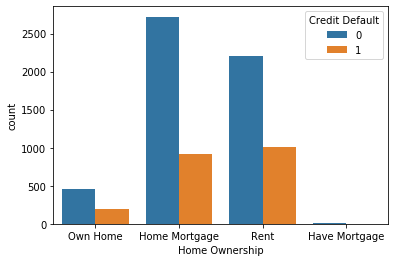

In [9]:
sns.countplot(dataTrain["Home Ownership"], hue=dataTrain["Credit Default"])
plt.show()

Матрица сопряженности для параметров Home Ownership и Credit Default:

In [10]:
owner_cont_tab = pd.crosstab(dataTrain["Home Ownership"], dataTrain["Credit Default"])
owner_cont_tab["Proportion of default"] = owner_cont_tab[1] / owner_cont_tab[0]
owner_cont_tab

Credit Default,0,1,Proportion of default
Home Ownership,,,
Have Mortgage,10,2,0.200000
Home Mortgage,2721,916,0.336641
Own Home,455,192,0.421978
Rent,2201,1003,0.455702


Исходя из таблицы можно сделать первоначальное предположение о том, что вероятность невозвратов кредитов больше всего у тех, кто арендует или имеет своё жильё. Но при этом стоить помнить, что параметр Have Mortgage встречается значительно реже в выборке, чем другие значения категорильного признака Home Ownership.

In [11]:
# Матрица ожидаемых значений
owner_cont_tab.drop("Proportion of default", axis=1, inplace=True)
owner_exp_tab = contingency.expected_freq(owner_cont_tab)
owner_exp_tab

array([[   8.6192    ,    3.3808    ],
       [2612.33586667, 1024.66413333],
       [ 464.71853333,  182.28146667],
       [2301.3264    ,  902.6736    ]])

In [12]:
# Матрица разниц между наблюдаемыми и ожидаемыми значениями (нормированная)
(owner_cont_tab - owner_exp_tab) / owner_exp_tab

Credit Default,0,1
Home Ownership,,
Have Mortgage,0.160200,-0.408424
Home Mortgage,0.041597,-0.106049
Own Home,-0.020913,0.053316
Rent,-0.043595,0.111144


Формулировка гипотезы более строго:

- H0: доля вернувших и не вернувших кредит не зависит от типа домовладения и значимо не отличается от среднего  по всей выборке процента возврата
- H1: альтернативная гипотеза - для данного типа домовладения доля вернувших и не вернувших кредит значимо отличается от средневыборочной.

Задача сводится к множественной проверке гипотезы о равенсте доли в независимых выборках.

In [13]:
label_all_full = dataTrain["Credit Default"]
p_vals = []
ownership = dataTrain["Home Ownership"].unique()
for os in ownership:
    def_os_i = dataTrain[dataTrain["Home Ownership"] == os]["Credit Default"]
    z_stat_i = proportions_diff_z_stat_ind(def_os_i, label_all_full)
    p_vals.append(proportions_diff_p_value(z_stat_i))
    
df_pVals = pd.DataFrame([(os, p_val) for os, p_val in zip(ownership, p_vals)], 
                        columns=["Home Ownership", "p-value"])
df_pVals

,Home Ownership,p-value
0,Own Home,0.415712
1,Home Mortgage,0.000891
2,Rent,0.001091
3,Have Mortgage,0.375856


In [14]:
# Поправка на множественную проверку гипотез:
_, p_vals_corr, _, _ = multipletests(df_pVals["p-value"], alpha = 0.05, method = "holm")
p_vals_corr

array([0.75171113, 0.00356293, 0.00356293, 0.75171113])

На уровне значимости 0.05 половина гипотез уверенно отвергается. Гипотезы, которые не отвергаются, представлены  маленьким количеством значений в выборке, что не позволяет оценить их объективно.

Можно сделать вывод, что вид домовладения статистически значимо влияет на вероятность невозврата кредита.

Далее проводится оценка степени корреляции невозврата кредитов с видом домовладения. Используем коэффициент корреляции V Крамера.

In [15]:
print("Коэффициент корреляции V Крамера:", getVCramer(owner_cont_tab))

Коэффициент корреляции V Крамера: 0.0664074765402524


Можно сделать вывод о низкой практической значимости параметра Home Ownership, как самостоятельного критерия оценки вероятности невозврата кредита

### 2. Annual Income - годовой доход

In [16]:
dataTrain["Annual Income"].head()

0     482087.0
1    1025487.0
2     751412.0
3     805068.0
4     776264.0
Name: Annual Income, dtype: float64

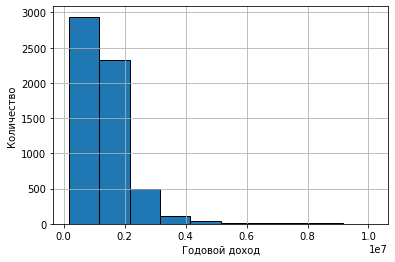

In [17]:
dataTrain["Annual Income"].hist(edgecolor='black', linewidth=1.)
plt.xlabel("Годовой доход")
plt.ylabel("Количество")

plt.show()

In [18]:
# Процент NaN в выборке по столбцу Annual Income
dataTrain["Annual Income"].isnull().sum()/dataTrain.shape[0]

0.2076

20% NaN в столбце Annual Income. Так как не хочется 20% выборки потерять,то перед обучением будем заполнять NaN.

Для оценки статистик и уровня влияния данного признака на метку необходимо произвести очистку NaN для данной фичи.

In [19]:
income_feature = dataTrain[["Credit Default", "Annual Income"]].dropna()

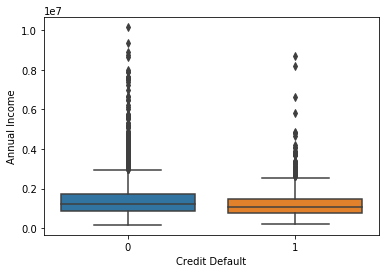

In [20]:
sns.boxplot(dataTrain["Credit Default"], dataTrain["Annual Income"])
plt.show()

Из графика можно предположить, что есть различие значений медиан двух распредлелений

Необходимо проверить более строго:
    - H0: нулевая гипотеза - медианы распределения по параметру Annual Income равны для выборок с Credit Default = 0 и Credit Default = 1
    - H1: альтернативная гипотеза (двусторонняя) - медианы распределений значимо отличаются

Проверка распределенияна нормальность

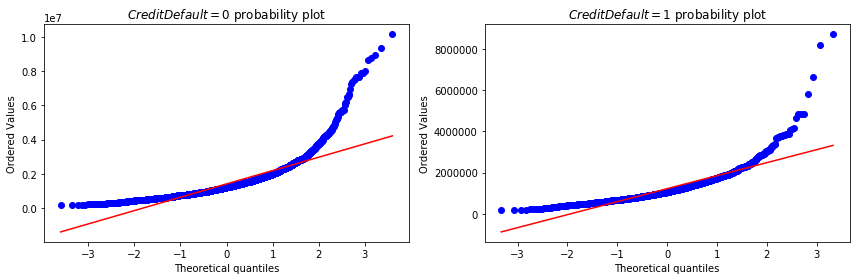

In [21]:
income_feature_true = income_feature[income_feature["Credit Default"] == 1]
income_feature_false = income_feature[income_feature["Credit Default"] == 0]
plot_qq(income_feature_false, income_feature_true, "Annual Income")

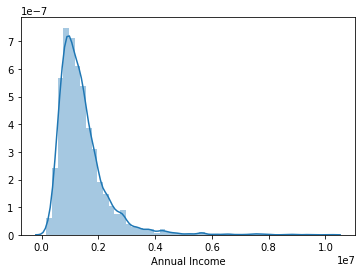

In [22]:
sns.distplot(income_feature_false["Annual Income"])
plt.show()

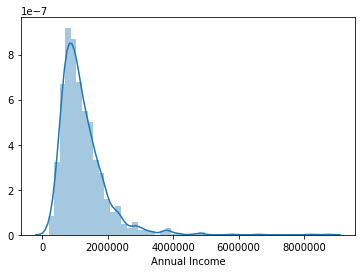

In [23]:
sns.distplot(income_feature_true["Annual Income"])
plt.show()

Исходя из графиков, распределение далеко от нормального, это значит, что нельзя использовать критерий Стьюдента. Зато можно применить непараметрические методы оценки доверительных интервалов и проверки гипотез.

Поэтому далее используется бутстрап-метод для оценки доверительного интеравала для медиан двух подвыборок:

In [24]:
def get_bootstrap_samples(data, n_samples):
    random_indeces = np.random.randint(0, len(data), (len(data), n_samples))
    return data[random_indeces]

def getBoundaries(stats, alpha):
    return np.percentile(stats, [100 * alpha / 2., 100 * (1 - alpha / 2.)])

bal_0_median_scores = list(map(np.median, 
                               get_bootstrap_samples(income_feature_false["Annual Income"].values, 1000)))
bal_1_median_scores = list(map(np.median, 
                               get_bootstrap_samples(income_feature_true["Annual Income"].values, 1000)))

In [25]:
print("Доверительный интервал для медианы Annual Income при Credit Default = 0:", 
      getBoundaries(bal_0_median_scores, 0.05))
print("Доверительный интервал для медианы Annual Income при Credit Default = 1:", 
      getBoundaries(bal_1_median_scores, 0.05))

Доверительный интервал для медианы Annual Income при Credit Default = 0: [1167483.5   1274260.175]
Доверительный интервал для медианы Annual Income при Credit Default = 1: [1025776.5125 1115842.2125]


Отсутствие пересечения доверительных интервалов означает возможность отвергнуть нулевую гипотезу на уровне доверия 95%. Распределения отличаются статистически значимо.

Дополнительно проверим практическую значимость по параметру Annual Income:

bal_bin
(154612.253, 1163071.7]    0.310204
(1163071.7, 2161546.4]     0.236661
(2161546.4, 3160021.1]     0.188139
(3160021.1, 4158495.8]     0.200000
(4158495.8, 5156970.5]     0.116279
(5156970.5, 6155445.2]     0.055556
(6155445.2, 7153919.9]     0.142857
(7153919.9, 8152394.6]     0.000000
(8152394.6, 9150869.3]     0.400000
(9150869.3, 10149344.0]    0.000000
Name: Credit Default, dtype: float64


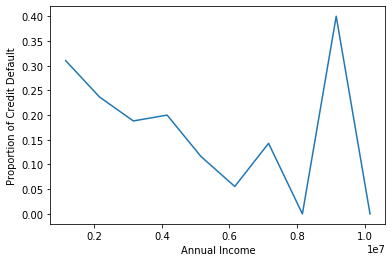

In [26]:
practical_sign(income_feature, "Annual Income", "Credit Default", bins=10)

Из графика можно предположить, что с ростом годового дохода доля невозвратов уверенно падает (хоть и наблюдается выборос на уровне дохода (8152394.6, 9150869.3]). Это подтверждает практическую значимость критерия Annual Income для оценки целевой переменной.

### 3. Years in current job - количество лет на текущем месте работы

In [27]:
# Процент NaN в выборке по столбцу Years in current job
dataTrain["Years in current job"].isnull().sum()/dataTrain.shape[0]

0.049466666666666666

5% NaN в столбце Years in current job.

In [28]:
dataTrain["Years in current job"].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Можно наблюдать, что всего встречается 11 разновидностей количества лет на текущем месте работы.
Проанализируем данный показатель, с точки зрения его влияния на метку.

Необходимо провести численную оценку гипотезы независимости параметров Years in current job и Credit Default:

   - H0 - нулевая гипотеза, согласно которой между Years in current job и Credit Default нет корреляции (они независимы);
   - H1 - альтернативная гипотеза - Years in current job и Credit Default значимо зависимы

In [29]:
year_cont_tab = pd.crosstab(dataTrain["Years in current job"], dataTrain["Credit Default"])
year_cont_tab["Proportion of default"] = year_cont_tab[1] / year_cont_tab[0]
year_cont_tab

Credit Default,0,1,Proportion of default
Years in current job,,,
1 year,362,142,0.392265
10+ years,1688,644,0.381517
2 years,512,193,0.376953
3 years,450,170,0.377778
4 years,338,131,0.387574
5 years,371,145,0.390836
6 years,302,124,0.410596
7 years,285,111,0.389474
8 years,247,92,0.372470


In [30]:
chi2 = chi2_contingency(year_cont_tab.iloc[:, :2])[1]
print("Достигаемый уровень значимости (p-value):", chi2)
print("Коэффициент корреляции V-Крамера", getVCramer(year_cont_tab))

Достигаемый уровень значимости (p-value): 0.9984533399948599
Коэффициент корреляции V-Крамера 0.014587757137424663


Можно сделать следующий вывод: критерий хи-квадрат позволил установить, что на уровне значимости 0.05 нулевую гипотезу отвергнуть нельзя, что говорит о малой статистической значимости параметра Years in current job. Корреляция также достаточно низкая, чтобы делать вывод о практической значимости параметра. При первичном обучении данный параметр можно не использовать.

### 4. Tax Liens - налоговое обременение

In [31]:
dataTrain["Tax Liens"].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

Числовой показатель, в котором наблюдается явное доменирование категории Tax Liens = 0.

In [32]:
tax_cont_tab = pd.crosstab(dataTrain["Tax Liens"], dataTrain['Credit Default'])
tax_cont_tab["Proportion of default"] = tax_cont_tab[1] / (tax_cont_tab[1] + tax_cont_tab[0])
tax_cont_tab

Credit Default,0,1,Proportion of default
Tax Liens,,,
0.0,5301,2065,0.280342
1.0,59,24,0.289157
2.0,15,15,0.500000
3.0,5,5,0.500000
4.0,3,3,0.500000
5.0,1,1,0.500000
6.0,2,0,0.000000
7.0,1,0,0.000000


Исходя из выше представленной таблицы можно сделать вывод о том, что значения признаков, которые не равны 0, мало информативны, и метка появляется ровно в 50% процентах случаях.

### 5. Number of Open Accounts - количество открытых счетов

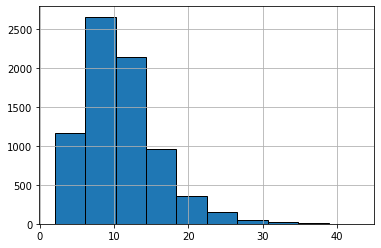

In [33]:
open_accounts_feature = dataTrain[["Number of Open Accounts", "Credit Default"]]
open_accounts_feature["Number of Open Accounts"].hist(edgecolor='black', linewidth=1.)
plt.show()

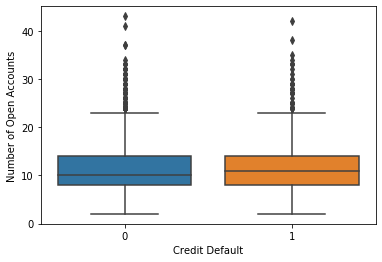

In [34]:
sns.boxplot(dataTrain["Credit Default"], dataTrain["Number of Open Accounts"])
plt.show()

Оценим выборку на нормальность с использование Q-Q графика.

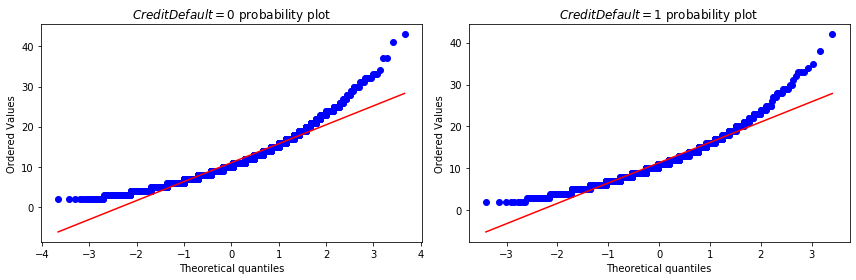

In [35]:
open_accounts_feature_true = open_accounts_feature[open_accounts_feature["Credit Default"] == 1]
open_accounts_feature_false = open_accounts_feature[open_accounts_feature["Credit Default"] == 0]
plot_qq(open_accounts_feature_false, open_accounts_feature_true, "Number of Open Accounts")

Графики наглядно демонстрируют отличие распределения от нормального. Это обосновывает применение непараметрических критериев для проверки гипотез. Необходимо провести оценку статистической значимости данного показателя.

Проверка гипотезы о идентичности распределений расчетным методом:

   - H0: нулевая гипотеза - распределения по параметру Number of Open Accounts значимо не отличаются для выборок с Credit Default = 0 и Credit Default = 1
   - H1: двусторонняя альтернатива - распределения значимо различны
   
Используем критерий Манна-Уитни для 2-х независимых выборок:

In [36]:
mannwhitneyu(open_accounts_feature_true["Number of Open Accounts"], 
             open_accounts_feature_false["Number of Open Accounts"], 
             alternative="two-sided")

MannwhitneyuResult(statistic=5916251.0, pvalue=0.007523292157607036)

Видно, что нулевая гипотеза уверенно отвергается на уровне значимости 0.05, т.е. действительно распределения отличаются статистически значимо.

Проведём оценку практической значимости данного показателя.

bal_bin
(1.959, 6.1]    0.268900
(6.1, 10.2]     0.274096
(10.2, 14.3]    0.284712
(14.3, 18.4]    0.296957
(18.4, 22.5]    0.314763
(22.5, 26.6]    0.261438
(26.6, 30.7]    0.367347
(30.7, 34.8]    0.300000
(34.8, 38.9]    0.500000
(38.9, 43.0]    0.333333
Name: Credit Default, dtype: float64


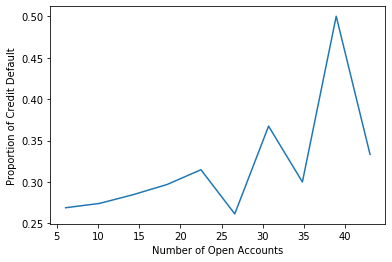

In [37]:
practical_sign(open_accounts_feature, "Number of Open Accounts", "Credit Default")

Исходя из графика можно наблюдать, что при увеличении количества открытых счетов увеличивается и вероятность невозврата кредитов. Можно предположить, что параметр Credit Default зависит от параметра Number of Open Accounts.

---
Для первых ПЯТИ фич я продемонстрировал более глубокий анализ с комментариями и моими мыслями.
Анализ остальных компонент мною были проведены самостоятельно, исходя из этого анализа было сформировано признаковое пространство, которое можно наблюдать в блоке "Обучение моделей и оценка их качества".
Если потребуется расписать анализ более подробно - пишите.

---

### Обучение моделей и оценка их качества

1. Подготовка данных для обучения и формирование новых признаков
2. Обучение моделей (catboost, lightgbm)
3. Оцека качества работы моделей по заявленным метрикам

In [782]:
dataTrain_v1 = dataTrain.copy()
useFeature_v1 = ["Home Ownership", "Annual Income", "Number of Open Accounts", 
                 "Maximum Open Credit", "Number of Credit Problems", "Bankruptcies", 
                 "Purpose", "Term", "Current Credit Balance", "Current Loan Amount", "Credit Score", 
                 "Monthly Debt"]

In [783]:
# Home Ownership
dataTrain_v1["Home Ownership"][dataTrain_v1["Home Ownership"] == "Have Mortgage"] = "Home Mortgage"
dataTrain_v1["Home Ownership"][dataTrain_v1["Home Ownership"] == "Own Home"] = "Home Mortgage"
labelEncOwn = preprocessing.LabelEncoder()
dataTrain_v1["Home Ownership"] = labelEncOwn.fit_transform(dataTrain_v1["Home Ownership"])

# Annual Income (number)
dataTrain_v1["Annual Income"] = dataTrain_v1["Annual Income"].fillna(dataTrain_v1["Annual Income"].mean())

# Maximum Open Credit (number)
percentile95 = np.percentile(dataTrain["Maximum Open Credit"], 95)
dataTrain_v1 = dataTrain_v1[dataTrain_v1["Maximum Open Credit"] < percentile95]

# Number of Credit Problems 
dataTrain_v1["Number of Credit Problems"][dataTrain_v1["Number of Credit Problems"] > 3.0] = 3

# Bankruptcies
dataTrain_v1 = dataTrain_v1.loc[dataTrain_v1["Bankruptcies"].dropna().index]
dataTrain_v1["Bankruptcies"][dataTrain_v1["Bankruptcies"] > 1.0] = 1

# Purpose
freqPurpose = dataTrain["Purpose"].value_counts()
dataTrain_v1["Purpose"][dataTrain_v1["Purpose"].isin(freqPurpose.index.tolist()[5:])] = "other"
labelEncPurpose = preprocessing.LabelEncoder()
dataTrain_v1["Purpose"] = labelEncPurpose.fit_transform(dataTrain_v1["Purpose"])

# Term
labelEncTerm = preprocessing.LabelEncoder()
dataTrain_v1["Term"] = labelEncTerm.fit_transform(dataTrain_v1["Term"])

# Current Loan Amount (number)
meanLoanAmount = dataTrain_v1["Current Loan Amount"][dataTrain_v1["Current Loan Amount"] != 99999999.0].mean()
dataTrain_v1["Current Loan Amount"][dataTrain_v1["Current Loan Amount"] == 99999999.0] = meanLoanAmount

# Credit Score
meanFalse = dataTrain_v1["Credit Score"][dataTrain_v1["Credit Default"] == 0].dropna().mean()
meanTrue = dataTrain_v1["Credit Score"][dataTrain_v1["Credit Default"] == 1].dropna().mean()

dataTrain_v1["Credit Score"][dataTrain_v1["Credit Default"] == 0] = dataTrain_v1["Credit Score"][
    dataTrain_v1["Credit Default"] == 0].fillna(meanFalse)
dataTrain_v1["Credit Score"][dataTrain_v1["Credit Default"] == 1] = dataTrain_v1["Credit Score"][
    dataTrain_v1["Credit Default"] == 1].fillna(meanTrue)

# Months since last delinquent
dataTrain_v1["Months since last delinquent"] = dataTrain_v1["Months since last delinquent"].fillna(0)

# Формирование новых признаков: Coeff income to loan - коэффициент соотношения дохода к размеру текущего кредита
# Balance money by month - приблизительный расчёт остатка средств на месяц после вычета ежемесячного платежа
dataTrain_v1["Coeff income to loan"] = dataTrain_v1["Annual Income"]/dataTrain_v1["Current Loan Amount"]
dataTrain_v1["Balance money by month"] = (dataTrain_v1["Annual Income"]/12) - dataTrain_v1["Monthly Debt"]

In [784]:
# Работа с числовыми и категориальными признаками
numberFeature = ["Balance money by month", "Number of Open Accounts", "Annual Income",
                 "Maximum Open Credit", "Monthly Debt", "Coeff income to loan", 
                 "Credit Score", "Months since last delinquent"]

catFeature = [x for x in dataTrain_v1[useFeature_v1].columns if x not in numberFeature + ["Current Credit Balance"]]

dataTrain_v1[catFeature] = dataTrain_v1[catFeature].astype(int)
ohenc = preprocessing.OneHotEncoder()
featureOhenc = ohenc.fit_transform(dataTrain_v1[catFeature]).toarray()

numCatFeature = list(range(len(catFeature)))
numNumberFeature = list(range(len(numberFeature)))

Обучим catboost с использованием классического разделения на обучения и тест

In [785]:
X_train, X_test, y_train, y_test = train_test_split(dataTrain_v1[numberFeature + catFeature], 
                                                    dataTrain_v1["Credit Default"], 
                                                    test_size=0.3)

In [786]:
scaler = preprocessing.StandardScaler()
X_train_scl = scaler.fit_transform(X_train[numberFeature])
X_test_scl = scaler.transform(X_test[numberFeature])

X_train = X_train[catFeature]
for i in range(len(numberFeature)):
    X_train[numberFeature[i]] = X_train_scl[:, i]

X_test = X_test[catFeature]
for i in range(len(numberFeature)):
    X_test[numberFeature[i]] = X_test_scl[:, i]

In [787]:
model = catboost.CatBoostClassifier(iterations=500,
                                    learning_rate=0.1,
                                    depth=3,
                                    loss_function='Logloss',
                                    eval_metric='F1',
                                    class_weights=class_weights,
                                    od_type='Iter',
                                    od_wait=100, 
                                    use_best_model=True,verbose=True)
model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=numCatFeature)

0:	learn: 0.6086524	test: 0.6056645	best: 0.6056645 (0)	total: 15.3ms	remaining: 7.62s
1:	learn: 0.6820221	test: 0.6973256	best: 0.6973256 (1)	total: 29.8ms	remaining: 7.41s
2:	learn: 0.6796411	test: 0.6910434	best: 0.6973256 (1)	total: 42.5ms	remaining: 7.04s
3:	learn: 0.6776701	test: 0.6880345	best: 0.6973256 (1)	total: 57.4ms	remaining: 7.11s
4:	learn: 0.6860038	test: 0.6903467	best: 0.6973256 (1)	total: 72.4ms	remaining: 7.17s
5:	learn: 0.6631677	test: 0.6605997	best: 0.6973256 (1)	total: 96.4ms	remaining: 7.94s
6:	learn: 0.6727893	test: 0.6741722	best: 0.6973256 (1)	total: 110ms	remaining: 7.76s
7:	learn: 0.6977880	test: 0.6981638	best: 0.6981638 (7)	total: 124ms	remaining: 7.62s
8:	learn: 0.7023306	test: 0.7015706	best: 0.7015706 (8)	total: 135ms	remaining: 7.36s
9:	learn: 0.6937224	test: 0.6938196	best: 0.7015706 (8)	total: 148ms	remaining: 7.26s
10:	learn: 0.6995287	test: 0.6963252	best: 0.7015706 (8)	total: 178ms	remaining: 7.93s
11:	learn: 0.7093245	test: 0.7093852	best: 0.70

106:	learn: 0.7699705	test: 0.7485266	best: 0.7541125 (103)	total: 2.15s	remaining: 7.91s
107:	learn: 0.7704523	test: 0.7482056	best: 0.7541125 (103)	total: 2.2s	remaining: 7.99s
108:	learn: 0.7698627	test: 0.7466130	best: 0.7541125 (103)	total: 2.23s	remaining: 8s
109:	learn: 0.7711653	test: 0.7478834	best: 0.7541125 (103)	total: 2.25s	remaining: 8s
110:	learn: 0.7712816	test: 0.7478834	best: 0.7541125 (103)	total: 2.29s	remaining: 8.02s
111:	learn: 0.7725750	test: 0.7492887	best: 0.7541125 (103)	total: 2.31s	remaining: 7.99s
112:	learn: 0.7738676	test: 0.7495431	best: 0.7541125 (103)	total: 2.33s	remaining: 7.98s
113:	learn: 0.7731631	test: 0.7508792	best: 0.7541125 (103)	total: 2.35s	remaining: 7.96s
114:	learn: 0.7749364	test: 0.7525268	best: 0.7541125 (103)	total: 2.37s	remaining: 7.94s
115:	learn: 0.7748201	test: 0.7509405	best: 0.7541125 (103)	total: 2.4s	remaining: 7.95s
116:	learn: 0.7750528	test: 0.7522721	best: 0.7541125 (103)	total: 2.43s	remaining: 7.95s
117:	learn: 0.7755

198:	learn: 0.8056527	test: 0.7497351	best: 0.7545274 (120)	total: 4.1s	remaining: 6.2s
199:	learn: 0.8061034	test: 0.7486592	best: 0.7545274 (120)	total: 4.14s	remaining: 6.21s
200:	learn: 0.8071232	test: 0.7484066	best: 0.7545274 (120)	total: 4.16s	remaining: 6.18s
201:	learn: 0.8082613	test: 0.7489120	best: 0.7545274 (120)	total: 4.18s	remaining: 6.17s
202:	learn: 0.8082613	test: 0.7486592	best: 0.7545274 (120)	total: 4.21s	remaining: 6.16s
203:	learn: 0.8076642	test: 0.7480870	best: 0.7545274 (120)	total: 4.22s	remaining: 6.12s
204:	learn: 0.8070956	test: 0.7489120	best: 0.7545274 (120)	total: 4.24s	remaining: 6.1s
205:	learn: 0.8088007	test: 0.7510623	best: 0.7545274 (120)	total: 4.26s	remaining: 6.08s
206:	learn: 0.8072427	test: 0.7499881	best: 0.7545274 (120)	total: 4.28s	remaining: 6.06s
207:	learn: 0.8079314	test: 0.7502412	best: 0.7545274 (120)	total: 4.3s	remaining: 6.04s
208:	learn: 0.8077836	test: 0.7499881	best: 0.7545274 (120)	total: 4.33s	remaining: 6.02s
209:	learn: 0.

In [788]:
thresholder = 0.5
count_metrics(model, X_test, y_test, thresholder=thresholder)

Матрица неточностей
F1 =  0.676923076923077
Recall =  0.6875
Precision =  0.6666666666666666


,0,1
0,1274,220
1,200,440


Обучим catboost с использованием кросс валидации

In [789]:
label = dataTrain_v1["Credit Default"]
scaler = preprocessing.StandardScaler()
Feauture_scl = scaler.fit_transform(dataTrain_v1[numberFeature])
dataTrain_cv = dataTrain_v1[catFeature]
for i in range(len(numberFeature)):
    dataTrain_cv[numberFeature[i]] = Feauture_scl[:, i]


cv_dataset = catboost.Pool(data=dataTrain_cv,
                  label=label,
                  cat_features=numCatFeature)

params = {"iterations": 150,
          "depth": 4,
          "eval_metric" : "F1",
          "loss_function": "Logloss",
          "class_weights": class_weights,
          "verbose": False}

scores = catboost.cv(cv_dataset,
                     params,
                     fold_count=10, 
                     plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучим lightgbm с использованием классического разделения на обучения и тест

In [790]:
lgbm = lgb.LGBMClassifier(max_depth=10, learning_rate=0.1, num_leaves=100,  
          n_estimators=100, class_weight=dict(zip([0, 1], class_weights)))

nameFeature = ['Home Ownership', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']
lgbm.fit(X_train, y_train, categorical_feature=nameFeature)

LGBMClassifier(boosting_type='gbdt',
               class_weight={0: 0.6961202895860404, 1: 1.7747278750591575},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=10, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=100,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [791]:
thresholder = 0.5
count_metrics(lgbm, X_test, y_test, thresholder=thresholder)

Матрица неточностей
F1 =  0.6432160804020101
Recall =  0.6
Precision =  0.6931407942238267


,0,1
0,1324,170
1,256,384


### Оценка модели на тестовом датасете

In [792]:
dataTest_v1 = dataTest.copy()

In [793]:
useFeature_v1 = ["Home Ownership", "Annual Income", "Number of Open Accounts", 
                 "Maximum Open Credit", "Number of Credit Problems", "Bankruptcies", 
                 "Purpose", "Term", "Current Credit Balance", "Current Loan Amount", "Credit Score", 
                 "Monthly Debt"]
# Home Ownership
dataTest_v1["Home Ownership"][dataTest_v1["Home Ownership"] == "Have Mortgage"] = "Home Mortgage"
dataTest_v1["Home Ownership"][dataTest_v1["Home Ownership"] == "Own Home"] = "Home Mortgage"
dataTest_v1["Home Ownership"] = labelEncOwn.transform(dataTest_v1["Home Ownership"])

# Annual Income (number)
dataTest_v1["Annual Income"] = dataTest_v1["Annual Income"].fillna(dataTest_v1["Annual Income"].mean())

# Number of Credit Problems 
dataTest_v1["Number of Credit Problems"][dataTest_v1["Number of Credit Problems"] > 3.0] = 3

# Bankruptcies
dataTest_v1["Bankruptcies"] = dataTest_v1["Bankruptcies"].fillna(0)
dataTest_v1["Bankruptcies"][dataTest_v1["Bankruptcies"] > 1.0] = 1

# Purpose
dataTest_v1["Purpose"][dataTest_v1["Purpose"].isin(freqPurpose.index.tolist()[5:])] = "other"
dataTest_v1["Purpose"] = labelEncPurpose.transform(dataTest_v1["Purpose"])

# Term
dataTest_v1["Term"] = labelEncTerm.transform(dataTest_v1["Term"])

# Current Loan Amount (number)
dataTest_v1["Current Loan Amount"][dataTest_v1["Current Loan Amount"] == 99999999.0] = meanLoanAmount

# Credit Score
countNan = dataTest_v1["Credit Score"].isnull().sum()
dataTest_v1["Credit Score"][dataTest_v1["Credit Score"].isnull()] = [
    np.random.choice([meanFalse, meanTrue]) for x in range(countNan)]

# Months since last delinquent
dataTest_v1["Months since last delinquent"].fillna(0, inplace=True)

# Формирование новых признаков: Coeff income to loan - коэффициент соотношения дохода к размеру текущего кредита
# Balance money by month - приблизительный расчёт остатка средств на месяц после вычета ежемесячного платежа
dataTest_v1["Coeff income to loan"] = dataTest_v1["Annual Income"]/dataTest_v1["Current Loan Amount"]
dataTest_v1["Balance money by month"] = (dataTest_v1["Annual Income"]/12) - dataTest_v1["Monthly Debt"]

In [794]:
test_scl = scaler.fit_transform(dataTest_v1[numberFeature])
dataTest_v1[catFeature] = dataTest_v1[catFeature].astype(int)
dataTest_predict_v1 = dataTest_v1[catFeature]
for i in range(len(numberFeature)):
    dataTest_predict_v1[numberFeature[i]] = test_scl[:, i]

In [795]:
df_predict_test = pd.DataFrame(model.predict(dataTest_predict_v1), columns=["Predict"])
df_predict_test

,Predict
0,1.0
1,1.0
2,1.0
3,0.0
4,1.0
5,0.0
6,0.0
7,1.0
8,1.0
9,0.0


In [801]:
model.save_model("./models/model_v1_catboost.cbm")

In [800]:
df_predict_test.to_csv("./resultPredict/resultPredict_v1.csv", index=False)